In [1]:
import pandas as pd 
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr
import hydroeval as he 
import seaborn as sns 
from tqdm import tqdm 
import warnings 

Set the algorithm options:

In [2]:
case_max = False

## include coordinates as feature 
omit_coords = True

## grid_format or single format 
grid_format = True

## similarity expression 
similarity_method = 'diff'

## calculate or load benchmarks 
calc_bench = False

## search window size 
set_buffer_size = 4

Set file paths and import files 

In [3]:
training_data_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\training_data_S1")
signature_dir = training_data_dir / "signatures_nc_V1_output"

## signature values 
fn_signatures = signature_dir / "S1_merged_signatures_v2-cleanup-1.csv"
df_signatures = pd.read_csv(fn_signatures, index_col = 0)

## gauge metadata  
fn_gauge =  training_data_dir / "V1_grdc_efas_selection-cartesius-snapped-1.csv" 
df_metadata_gauge = pd.read_csv(fn_gauge, index_col = 0)

## benchmark data 
fn_bench = signature_dir / "S1_benchmarks_set1.csv" 

## otuput dir
output_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis")

Display signature values:

In [4]:
df_signatures

,Nm-all,Ns-all,N-gof-all,Lm-all,Ls-all,L-gof-all,Gu-all,Ga-all,Gev-gof-all,Gk-all,...,flv-seasonal_1,hf-f-all,hf-f-seasonal_1,hf-t-all,lf-f-all,lf-f-seasonal_1,lf-t-seasonal_1,pks-all,tag,dem_flag
ID,,,,,,,,,,,,,,,,,,,,,
6119010_11,102.035362,106.090645,0.0,4.221500,0.863208,0.0,54.306767,0.012089,0.0,0.925012,...,164.721008,0.590909,0.0,2.954545,0.363636,0.636364,4.481481,666.803894,6119010,0
6119010_12,100.917046,105.168777,0.0,4.209119,0.864435,0.0,53.603184,0.012195,0.0,0.920779,...,163.700439,0.590909,0.0,3.090909,0.363636,0.636364,4.518519,654.762268,6119010,0
6119010_13,0.544169,0.542255,0.0,-1.002645,0.867551,0.0,0.300217,2.365214,0.0,1.007072,...,266.693390,0.409091,0.0,1.727273,0.409091,0.636364,6.000000,3.131104,6119010,0
6119010_14,162.321777,138.910507,0.0,4.760090,0.835850,0.0,99.828016,0.009233,0.0,1.365474,...,317.679565,0.045455,0.0,0.136364,1.000000,0.545455,7.227273,723.082581,6119010,0
6119010_15,17.163115,16.641987,0.0,2.442999,0.888787,0.0,9.676133,0.077067,0.0,1.063609,...,248.398575,0.136364,0.0,0.363636,0.454545,0.500000,6.083333,98.092957,6119010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983350_96,522.018127,325.349060,0.0,6.080506,0.592225,0.0,375.648448,0.003942,0.0,2.574376,...,60.206692,0.000000,0.0,0.000000,0.111111,0.000000,0.000000,1890.435181,6983350,0
6983350_97,1.769354,1.644365,0.0,0.271318,0.743112,0.0,1.029579,0.779967,0.0,1.157798,...,73.878761,0.333333,0.0,1.000000,0.111111,0.555556,6.181818,10.525513,6983350,0
6983350_98,6.406629,5.884712,0.0,1.530997,0.797030,0.0,3.759185,0.217946,0.0,1.185247,...,92.737022,0.444444,0.0,1.000000,0.444444,0.444444,4.800000,33.151855,6983350,0


Slightly expand the searching area by labeling the up- and downstream neigbhours of the target pixel as 1

In [5]:
def expand_labels(df, id_col, target_col, critical_variable, 
                  p_diff = 5., n_max = 3, pixel_size = 5000., 
                  x_coord = 'x', y_coord = 'y'):
    
    out_col = 'range_{}'.format(target_col)
    df[out_col] = 0.
    
    for bix in df[id_col].unique():
        
        ## select buffer and target value 
        _buffer = df[ df[id_col] == bix ] 
        
        ## discard gauge values 
        buffer_ix = [ix for ix in _buffer.index if not 'gauge' in ix]
        _sim = _buffer.loc[buffer_ix] 
        
        ## select target row 
        target = _sim[ _sim[target_col] == 1.]
        
        ## if target value found
        if len(target) > 0:
            
            ## search criterium 
            target_var = target[critical_variable].values[0] 
            
            ## look to adjacent pixels only 
            target_X_coord = target[x_coord].values[0]
            target_Y_coord = target[y_coord].values[0] 
            x_filter = (_sim[x_coord] >= target_X_coord - 2*(pixel_size+1.) ) & (_sim[x_coord] <= target_X_coord + 2*(pixel_size+1.))
            y_filter = (_sim[y_coord] >= target_Y_coord - 2*(pixel_size+1.) ) & (_sim[y_coord] <= target_Y_coord + 2*(pixel_size+1.))
            _sim = _sim[ x_filter & y_filter]

            ## calculate absolute percentual difference 
            d_var = (( ((_sim[critical_variable] - target_var)**2)**0.5 / target_var)*100 ).sort_values()
            
            ## select based on a percentual limit (1% - 5%) 
            expand_targets = d_var[ d_var <= p_diff].index
            if len(expand_targets) > n_max:
                expand_targets = expand_targets[:int(n_max-1)]

            ## relabel 
            if target.index[0] in expand_targets:
                df.loc[expand_targets, out_col] = 1 
            else:
                print('check ', bix)            

    return df, out_col

In [6]:
df_signatures, range_col = expand_labels(df_signatures, 'tag', 'target', 'Nm-all', p_diff = 1.) 

Set the label categories - identify feature columns and target labels. Used for later processing of similarity and splitting X and y

In [7]:
## column descriptors 
columns = df_signatures.columns.values 

## target value to predict 
target_col = ['target'] 

## target for continued search 
target_buffer = ['in_buffer']

## the following columns should be omitted from the training dataset
## but they are be useful for easy selection and analysis 
## dem_flag only 1 for gauge values
non_feature_cols = ['n_buffer', 'tag', 'dem_flag', range_col, 'in_buffer'] 

## coord cols - could be ommitted from dataset, risk for overfitting
## and also takes away focus on selection based on timeseries
coord_cols = ['x', 'y', 'lat', 'lon']

## features that do not have to be transformed by subtraction 
## and cross-correlation properties, that are already a similarity property 
## as they are cross-correlation values of simulations and observations
non_similarity_cols = [col for col in columns if 'clag' in col]

## remove the non_feature and target columns from the columns list to 
## create a list with feature columns 
feature_cols = [col for col in columns if (col not in non_feature_cols) & (not 'target' in col)]

## if coord_cols ommitted, remove them from the feature columns:
if omit_coords:
    feature_cols = [col for col in feature_cols if col not in coord_cols] 

## columns on which to perform similarity calculations:
calc_cols = [col for col in feature_cols if col not in non_similarity_cols]

Set the similarity metric used by the algorithm to find a best matching simulation

In [8]:
## calculate similarity per buffer 

def calc_similarity(df, buffer_col, calc_cols,
                   methods = ['diff']):
    
    df_out = df.copy() 
    
    buffer_idx = df[buffer_col].unique() 
    
    for ix in buffer_idx:
        df_buffer = df[ df[buffer_col] == ix] 
        
        cell_index = [row for row in df_buffer.index if not 'gauge' in row]
        gauge_index = [row for row in df_buffer.index if 'gauge' in row] 
        
        if len(gauge_index) > 0:
                
            if 'diff' in methods:            
                for col in calc_cols:
                    df_out.loc[cell_index, 'diff_{}'.format(col)] = df_out.loc[cell_index, col] - df_out.loc[gauge_index, col].values

            if 'abs' in methods:
                for col in calc_cols:
                     df_out.loc[cell_index, 'abs_{}'.format(col)] = ((df_out.loc[cell_index, col] - df_out.loc[gauge_index, col].values)**2)**0.5 

            if 'ratio-1' in methods:
                for col in calc_cols:
                    df_out.loc[cell_index, 'rat1_{}'.format(col)] = 1 - (( df_out.loc[cell_index, col] / (df_out.loc[gauge_index, col].values+1e-6)  )**2)**0.5

            if 'ratio-2' in methods:
                for col in calc_cols:
                    df_out.loc[cell_index, 'rat2_{}'.format(col)] =  ( df_out.loc[cell_index, col] - df_out.loc[gauge_index, col].values ) / (df_out.loc[gauge_index, col].values+1e-6)
            
            if 'double' in methods: 
                for col in calc_cols:
                    df_out.loc[cell_index, 'sim_{}'.format(col)] = df_out.loc[cell_index, col]
                    df_out.loc[cell_index, 'obs_{}'.format(col)] = df_out.loc[gauge_index, col].values[0]
        
        else:
            print('No gauge? :', ix)
            df_out = df_out.drop(index=cell_index)
                    
    ## drop calc_cols
    df_out = df_out.drop(columns=calc_cols)
    
    gauge_idx = [row for row in df_out.index if 'gauge' in row] 
    return df_out.drop(index=gauge_idx)

In [9]:
df_similarity = calc_similarity(df_signatures, 'tag', calc_cols, methods=[similarity_method])

df_similarity

,clag-0-all,clag-1-all,clag-0-seasonal_1,clag-1-seasonal_1,n_buffer,x,y,lat,lon,target,...,diff_fhv-seasonal_1,diff_flv-all,diff_flv-seasonal_1,diff_hf-f-all,diff_hf-f-seasonal_1,diff_hf-t-all,diff_lf-f-all,diff_lf-f-seasonal_1,diff_lf-t-seasonal_1,diff_pks-all
ID,,,,,,,,,,,,,,,,,,,,,
6119010_11,0.635464,0.544323,0.672078,0.537085,4.0,3422500.0,2352500.0,43.678226,-1.161527,0.0,...,8108.892578,-1091.800362,47.776888,0.454545,-0.045455,2.818182,0.318182,0.636364,4.481481,328.303894
6119010_12,0.635464,0.544067,0.671657,0.536465,4.0,3422500.0,2347500.0,43.633678,-1.152881,0.0,...,7921.990234,-1094.935036,46.756319,0.454545,-0.045455,2.954545,0.318182,0.636364,4.518519,316.262268
6119010_13,0.589989,0.522277,0.698611,0.582520,4.0,3422500.0,2342500.0,43.589130,-1.144252,0.0,...,-14805.981384,-713.167183,149.749269,0.272727,-0.045455,1.590909,0.363636,0.636364,6.000000,-335.368896
6119010_14,0.709440,0.570481,0.822756,0.639700,4.0,3422500.0,2337500.0,43.544575,-1.135641,0.0,...,11030.318359,-133.411201,200.735445,-0.090909,-0.045455,0.000000,0.954545,0.545455,7.227273,384.582581
6119010_15,0.612656,0.531497,0.700380,0.568576,4.0,3422500.0,2332500.0,43.500019,-1.127047,0.0,...,-11723.430176,-538.359810,131.454454,0.000000,-0.045455,0.227273,0.409091,0.500000,6.083333,-240.407043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6983350_95,0.203398,0.227645,0.419789,0.451424,4.0,6502500.0,2872500.0,45.141037,38.478489,0.0,...,-14710.986877,-476.378696,48.027616,0.777778,0.111111,1.555556,0.000000,0.555556,6.000000,-990.893250
6983350_96,0.574453,0.580212,0.581299,0.579456,4.0,6502500.0,2867500.0,45.099716,38.455753,0.0,...,-2752.287109,-400.673678,29.618272,0.000000,0.000000,0.000000,-0.111111,0.000000,0.000000,897.935181
6983350_97,0.234536,0.260122,0.485846,0.515676,4.0,6502500.0,2862500.0,45.058388,38.433064,0.0,...,-14548.157715,-373.953403,43.290342,0.333333,0.000000,1.000000,-0.111111,0.555556,6.181818,-981.974487


Import required scikit-learn functions

In [10]:
# preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.decomposition import PCA

# algorithms 
from sklearn.linear_model import LogisticRegression 
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

# evaluation 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, balanced_accuracy_score 

Split a training & evaluation and test set: first investigate location of targets. Split datasets based on those distributions for equal division of shifts required between the initial and reperesentative location

In [11]:
## first split data based on being inside or outside the buffer zone (=4)
df_outside_buffer = df_similarity[ df_similarity['target'] == -1].copy() 
gauge_outside = df_outside_buffer['tag'].unique().astype(int)

## analyse large shifts 
df_meta_gauge = df_metadata_gauge.loc[gauge_outside]
print('{} gauges / buffers fall outside the buffer zone of 4:'.format(len(gauge_outside)))
print(df_meta_gauge[['d_X_cell', 'd_Y_cell']].describe())
# print(df_meta_gauge[['d_X_cell', 'd_Y_cell']])

23 gauges / buffers fall outside the buffer zone of 4:
         d_X_cell    d_Y_cell
count   23.000000   23.000000
mean   -20.826087   -6.086957
std     55.257786   54.266106
min   -214.000000 -250.000000
25%    -11.500000   -1.000000
50%     -4.000000    6.000000
75%      2.000000   10.500000
max     13.000000   30.000000


In [12]:
## copy data to new dataframe 
df_predict_buffer = df_similarity.copy() #.drop(index=df_outside_buffer.index) 
## set all outside buffer vals from -1 to 0 
df_predict_buffer.loc[df_outside_buffer.index, 'target'] = 0. 
## add target column for in-buffer prediction 
df_predict_buffer['in_buffer'] = 1 
df_predict_buffer.loc[ df_predict_buffer['tag'].isin(gauge_outside)  , 'in_buffer'] = 0.

In [13]:
print('\nAnalyse size of buffer or searching range with number of hits:')
for buffer_size in np.sort(df_predict_buffer['n_buffer'].unique()):
    n_hits =df_predict_buffer[ (df_predict_buffer['n_buffer'] == buffer_size) & (df_predict_buffer['target']==1.) ]['target'].sum()
    print('In a search range of {:.0f} cells, {:.0f} matches are found'.format(buffer_size, n_hits))


Analyse size of buffer or searching range with number of hits:
In a search range of 0 cells, 244 matches are found
In a search range of 1 cells, 284 matches are found
In a search range of 2 cells, 32 matches are found
In a search range of 3 cells, 9 matches are found
In a search range of 4 cells, 3 matches are found


In [14]:
## get buffers based on location of match 
buffer_0 = df_predict_buffer[ (df_predict_buffer['n_buffer'] == 0) & (df_predict_buffer['target']==1) ]['tag'].unique()
buffer_1 = df_predict_buffer[ (df_predict_buffer['n_buffer'] == 1) & (df_predict_buffer['target']==1) ]['tag'].unique()
buffer_2 = df_predict_buffer[ (df_predict_buffer['n_buffer'] == 2) & (df_predict_buffer['target']==1) ]['tag'].unique()
buffer_3 = df_predict_buffer[ (df_predict_buffer['n_buffer'] == 3) & (df_predict_buffer['target']==1) ]['tag'].unique()
buffer_4 = df_predict_buffer[ (df_predict_buffer['n_buffer'] == 4) & (df_predict_buffer['target']==1) ]['tag'].unique()

## split with same ratio 
train_val_0, test_0 = train_test_split(buffer_0, test_size=0.15, random_state=21)
train_val_1, test_1 = train_test_split(buffer_1, test_size=0.15, random_state=21)
train_val_2, test_2 = train_test_split(buffer_2, test_size=0.15, random_state=21)
train_val_3, test_3 = train_test_split(buffer_3, test_size=0.15, random_state=21)
train_val_4, test_4 = train_test_split(buffer_4, test_size=0.15, random_state=21)
train_val_out, test_out = train_test_split(gauge_outside, test_size=0.15, random_state=21)

## combine all sets 
train_val_sets = (train_val_0, train_val_1, train_val_2, train_val_3, train_val_4, train_val_out)
test_sets = (test_0, test_1, test_2, test_3, test_4, test_out)

id_train_val = np.concatenate( train_val_sets )
id_test = np.concatenate( test_sets )

## split data 
df_train_val = df_predict_buffer[ df_predict_buffer['tag'].isin(id_train_val)].copy()
df_test = df_predict_buffer[ df_predict_buffer['tag'].isin(id_test) ].copy()

## VARY SEARCHING AREA
## drop all rows with n_buffer values > set_buffer_size
## if match outside buffer, remaining set will be all zeros --> no buffer in current search area 
df_train_val = df_train_val[ df_train_val['n_buffer'] <= set_buffer_size ].copy()
df_test = df_test[ df_test['n_buffer'] <= set_buffer_size ].copy()

## update in_buffer values 
for gauge_id in id_train_val:
    idx = df_train_val[ df_train_val['tag']== gauge_id].index 
    sum_target = df_train_val.loc[idx, 'target'].sum()
    if sum_target < 1:
        df_train_val.loc[idx, 'in_buffer'] = 0 

for gauge_id in id_test:
    idx = df_test[ df_test['tag']== gauge_id].index 
    sum_target = df_test.loc[idx, 'target'].sum()
    if sum_target < 1:
        df_test.loc[idx, 'in_buffer'] = 0 

######         
print('\nShow result of split:')
print('Train val set:')
print( df_train_val[df_train_val['target']==1].groupby(by='n_buffer')['target'].sum() )
print('\nTest set')
print( df_test[df_test['target']==1].groupby(by='n_buffer')['target'].sum() )
print(f'\n{len(id_train_val)} samples in total train val set')
print(f'{len(id_test)} samples in total train val set')


Show result of split:
Train val set:
n_buffer
0.0    207.0
1.0    241.0
2.0     27.0
3.0      7.0
4.0      2.0
Name: target, dtype: float64

Test set
n_buffer
0.0    37.0
1.0    43.0
2.0     5.0
3.0     2.0
4.0     1.0
Name: target, dtype: float64

503 samples in total train val set
92 samples in total train val set


In [15]:
## update list with feature columns 
feature_columns = df_similarity.columns.values 

## remove non_feature cols 
for col in non_feature_cols+target_col+coord_cols:
    col_ix = np.where(feature_columns==col)[0]
    feature_columns = np.delete(feature_columns, col_ix)

Load or calculate benchmark predictions

In [16]:
def benchmarks(df, id_col, target_col, obs_dir = None, sim_dir = None,
               methods = ['CC', 'NSE', 'RMSE', 'KGE'],
               fn_out = None): 
    
    df_out = pd.DataFrame() 
    
    df_out['ID'] = df.index.values 
    df_out[id_col] = df[id_col].values 
    df_out[target_col] = df[target_col].values 
    df_out = df_out.set_index('ID')
    
    buffer_idx = df_out[id_col].unique()
    
    for i in tqdm(range(len(buffer_idx))):
        buffer_id = buffer_idx[i]
        
        _out = df_out[ df_out[id_col] == buffer_id] 
                
        for method in methods:
            
            out_col = '{}_hat-{}'.format(target_col, method)
            
            if method in ['NSE', 'RMSE', 'KGE']:
                
                assert obs_dir.exists() , '[ERROR] obs_dir not specified or not found'
                assert sim_dir.exists(), '[ERROR] sim_dir not specified or not found'
                
                fn_obs = obs_dir / '{}_Q_Day.Cmd.txt'.format(buffer_id)
                fn_sim = sim_dir / 'buffer_{}_size-4.nc'.format(buffer_id) 
                
                ## load observations
                df_obs = pd.read_csv(fn_obs, skiprows=36, delimiter=';', encoding='cp850')
                df_obs['Q_obs'] = df_obs[' Value'] 
                df_obs['date'] = pd.to_datetime(df_obs['YYYY-MM-DD'], yearfirst=True,
                                               format='%Y-%m-%d')
                df_obs = df_obs.drop(columns=[' Value', 'YYYY-MM-DD', 'hh:mm'])
                df_obs = df_obs.set_index('date')
                df_obs.loc[ df_obs['Q_obs'] == -999., 'Q_obs'] = np.nan 
                df_obs = df_obs.loc[df_obs.index >= '1991']
                
                ## load simulations 
                ds_sim = xr.open_dataset(fn_sim)
                df_sim_list = ds_sim.to_dataframe().reset_index() 
                
                df_sim = pd.DataFrame()
                df_sim['date'] = pd.to_datetime( df_sim_list['time'].unique() )
                df_sim  = df_sim.set_index('date')
                
                for i, x_cell in enumerate( df_sim_list['x'].unique() ):
                    for j, y_cell in enumerate( df_sim_list['y'].unique() ):
                        
                        _df = df_sim_list[ (df_sim_list['x'] == x_cell) & (df_sim_list['y'] == y_cell) ]
                        
                        cell_id = '{}_{}{}'.format(buffer_id, int(i+1), int(j+1)) 
                        time = pd.to_datetime(_df['time'])
                        df_sim.loc[time, cell_id] = _df['dis24'].values 
                
                ## set simulations to observations extent 
                max_date = df_obs.tail(1).index.values[0]
                min_date = df_obs.head(1).index.values[0]
                df_sim = df_sim.loc[ (df_sim.index>=min_date) & (df_sim.index <= max_date)].copy()    
                
                ## mask and drop NaN values based on observations 
                gauge_mask = df_obs[df_obs['Q_obs'].isnull()>0].index 
                df_obs = df_obs.drop(index=gauge_mask)
                df_sim = df_sim.drop(index=gauge_mask)   
                
                ## calculate selected metrics in the buffer 
                for cell in df_sim.columns:
                    
                    if method == 'NSE':
                        try:
                            res = he.evaluator(he.nse, df_sim[cell].values, df_obs['Q_obs'].values )[0]
                        except:
                            print(buffer_id)
                            print(df_obs.head(2))
                            print(df_obs.tail(2))
                            print(df_sim.head(2).index)
                            print(df_sim.tail(2).index)
                            
                        
                    if method == 'RMSE':
                        res = he.evaluator(he.rmse, df_sim[cell].values, df_obs['Q_obs'].values )[0]  
                        
                    if method == 'KGE':
                        res, r, alpha, beta = he.evaluator(he.kge, df_sim[cell].values, df_obs['Q_obs'].values ) 

                    df_out.loc[cell, method] = res 
                
                if method == 'NSE':
                    y_hat_ix = df_out.loc[_out.index, method].idxmax()
                if method == 'RMSE':
                    y_hat_ix = df_out.loc[_out.index, method].idxmin()
                if method == 'KGE':
                    y_hat_ix = df_out.loc[_out.index, method].idxmax()
                        
                
                df_out.loc[_out.index, out_col] = 0 
                df_out.loc[y_hat_ix, out_col] = 1

            if method == 'CC': 
                df_out.loc[ _out.index, out_col ] = 0 
                center_ix = df[ (df['n_buffer'] == 0) & (df[id_col]==buffer_id)].index
                df_out.loc[center_ix, out_col] = 1 
            
    df_out = df_out.dropna(axis=0)
                
    if fn_out == None:
        return df_out
    else:
        df_out.to_csv(fn_out)
        return fn_out 

In [17]:
## load or calculate benchmarks 


if calc_bench:

#     base_dir = Path(r"C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\training_data_S1") 

    obs_dir = training_data_dir / "V1" 
    sim_dir = training_data_dir / "efas_output_nc"

    df_benchmarks = benchmarks(df_similarity, 'tag', target_col[0], 
                               obs_dir, sim_dir) #, fn_out = fn_bench)

else:
    df_benchmarks = pd.read_csv(fn_bench, index_col=0)

df_benchmarks

,tag,target,target_hat-CC,NSE,target_hat-NSE,RMSE,target_hat-RMSE,KGE,target_hat-KGE,range_target
ID,,,,,,,,,,
6119010_11,6119010.0,0.0,0.0,-1.104252,0.0,85.764867,0.0,0.073359,0.0,0.0
6119010_12,6119010.0,0.0,0.0,-1.053343,0.0,84.721030,0.0,0.091422,0.0,0.0
6119010_13,6119010.0,0.0,0.0,-1.706547,0.0,97.267627,0.0,-0.461489,0.0,0.0
6119010_14,6119010.0,0.0,0.0,-4.219406,0.0,135.073783,0.0,-0.752973,0.0,0.0
6119010_15,6119010.0,0.0,0.0,-0.793922,0.0,79.188540,0.0,-0.129047,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6983350_95,6983350.0,0.0,0.0,-3.263031,0.0,472.606324,0.0,-0.622039,0.0,0.0
6983350_96,6983350.0,0.0,0.0,-0.610899,0.0,290.518893,0.0,0.346487,0.0,0.0
6983350_97,6983350.0,0.0,0.0,-3.236569,0.0,471.137243,0.0,-0.600964,0.0,0.0


In [18]:
## update benchmark data 
df_benchmarks['n_buffer'] = df_similarity['n_buffer'] 
df_benchmarks['range_target'] = df_similarity['range_target']

## set all outside buffer vals from -1 to 0 
df_benchmarks.loc[df_outside_buffer.index, 'target'] = 0. 

## split training and validation data 
benchmarks_train_val = df_benchmarks.loc[df_train_val.index].copy()
benchmarks_test = df_benchmarks.loc[df_test.index].copy()

Now, prepare functions for performance evaluation and classification

In [19]:
## these functions are used for grid formatting 

def feature_grid(df, feature_cols, target_col, range_col=None, n_elements=9):
    
    ## create  multidimensional array with NaN value: -999. 
    feature_grid = np.ones((len(feature_cols), n_elements, n_elements)) * -999. 
    target_grid = np.zeros((n_elements, n_elements))
    
    range_grid = None 
    if range_col != None:
        range_grid = np.zeros((n_elements, n_elements))
        
    ## fill array 
    for ix in df.index:
        grid_x, grid_y = int(ix.split('_')[-1][0]), int(ix.split('_')[-1][1]) 
                
        feature_grid[:, int(grid_y-1), int(grid_x-1) ] = df.loc[ix, feature_cols].values 
        target_grid[int(grid_y-1),int(grid_x-1)] = df.loc[ix, target_col] 
        
        if range_col!= None:
            range_grid[int(grid_y-1),int(grid_x-1)] = df.loc[ix, range_col]
                     
    return feature_grid, target_grid, range_grid

def reshape_to_grid(df, feature_cols, target_col, range_col=None, id_col='tag', buffer_size=4):
    
    n_elements = int(1 + (2*buffer_size))
    
    ## create emtpy output grids 
    grid_features = np.zeros((df[id_col].nunique(), len(feature_cols), n_elements, n_elements )) 
    grid_targets = np.zeros((df[id_col].nunique(), n_elements, n_elements))
    
    grid_range = None
    if range_col != None:
        grid_range = np.zeros((df[id_col].nunique(), n_elements, n_elements))
    
    ## reshape each buffer 
    for i, idx in enumerate(df[id_col].unique()):
#     for i, idx in tqdm(enumerate(df[id_col].unique())):
                
        df_buffer = df[ df[id_col] == idx ] 
        
        grid_buffer_features, grid_buffer_target, grid_buffer_range = feature_grid(df_buffer, feature_cols, 
                                                                                   target_col, range_col, n_elements) 
            
        grid_features[i] = grid_buffer_features
        grid_targets[i] = grid_buffer_target
        
        if range_col != None:
            grid_range[i] = grid_buffer_range
    
    if range_col == None:
        return grid_features, grid_targets 
    
    return grid_features, grid_targets, grid_range

In [20]:
## these functions support performance evaluation and interpretation of predictions 

def evaluate_performances(y, y_hat, k, model_name, grid_format = False,
                          id_col='tag', target_col='range_target'):
    
    ## customize classifcation evaluation
    TP = 0 
    TN = 0
    FP = 0
    FN = 0 
    n_targets = 0 
    
    if grid_format:
        
        n_samples, n_classes = y.shape 
        n_cells = n_samples * n_classes 
        n_samples, n_classes = y.shape       
        
        ## reshape to count TP, TN, FP, FN 
        for sample in range(len(y)):
            
            row_y = y[sample]
            row_y_hat = y_hat[sample]
            
            ix_y = np.where(row_y > 0)[0]
            ix_y_hat = np.where(row_y_hat > 0)[0]

            ## positve target label exists 
            if len(ix_y) > 0:
                n_targets += 1 
            
                ## if a positive target label exists, and 
                ## prediction contains a positive label, 
                ## prediction is either true or false 
                if len(ix_y_hat) > 0:
                    
                    ## if prediction true, TP = 1 and TN are remaining cells 
                    if ix_y_hat[0] in ix_y:
                        TP += 1 
                        TN += (n_classes-1)
                    
                    ## if prediction is false, TP = 1 and TN are remaining cells 
                    if ix_y_hat[0] not in ix_y:
                        FP += 1                    # or sum(row_y) ?, so 1-3 false positives)
                        TN += (n_classes-2)        # or n_classes - sum(row_y)
                        FN += 1 
                
                ## if a positive target label exists, but
                ## prediction is all zeros, false negatives are counted 
                else: 
                    FN += 1 
                    TN += (n_classes-1)
            
            ## no positive labels 
            if len(ix_y) == 0:
                ## and prediction correctly all zero as well 
                if len(ix_y_hat) == 0:
                    TN += n_classes 
                    
                ## else one label is incorrectly labelled positive 
                ## rest is true negative 
                else:
                    FP += 1
                    TN += (n_classes-1)
                    
    else:
        
        ## reshape to count TP, TN, FP, FN 
        y['hat'] = y_hat
        n_cells = len(y) 
        
        for ix in y[id_col].unique():
            _buffer = y[ y[id_col] == ix ]
            
            n_classes = len(_buffer)
            
            _y = _buffer[target_col]
            _y_hat = _buffer['hat']
            
            ## if positive target
            if _y.sum() > 0:
                n_targets += 1 
                _y_ix = _y[ _y>0].index.values 

                ## if positive prediction 
                if _y_hat.sum() > 0:
                    _y_hat_ix = _y_hat.idxmax() 
                    
                    ## if correct prediction 
                    if _y_hat_ix in _y_ix:
                        TP += 1 
                        TN += (n_classes-1)
                    ## incorrect prediction
                    else:
                        FP += 1
                        TN += (n_classes-2)
                        FN += 1 
                        
                ## if no positive prediction
                else:
                    FN += 1 
                    TN += (n_classes-1)
                    
            ## if no positive targets 
            else:
                ## if no positive predictions 
                if _y_hat.sum() == 0:
                    TN += n_classes
                ## if positive predictions 
                else:
                    FP += 1
                    TN += (n_classes-1)
    
    ## calculate metrics 
    acc = (TP+TN) / (TP+TN+FP+FN)
    b_acc = 0.5 * ( (TP/(TP+FN+1e-6)) + (TN/(TN+FP+1e-6))  )
    prec = TP / (TP+FP+1e-6)
    rec = TP / (TP+FN+1e-6) 
    f1 = (prec*rec) / (prec+rec+1e-6) 
    hit_rate = TP / n_targets 

    return_df = pd.DataFrame({
                            'k': [k],
                            'model': [model_name],
                            'accuracy': [acc],
                            'balanced_acc': [b_acc],
                            'precision': [prec],
                            'recall': [rec],
                            'f1': [f1],
                            'hit_rate': [hit_rate],
                            'n': [n_targets],
                            'N': [n_cells],
                            'TP': [TP],
                            'TN': [TN],
                            'FP': [FP],
                            'FN': [FN]
                              })     
    return return_df


def buffer_classifier(df_val, y_prob, p0_col, p1_col,
                     prediction_col, id_col, prob_threshold):
        
    df_val[p0_col] = y_prob[:,0]
    df_val[p1_col] = y_prob[:,1] 
    df_val[prediction_col] = 0.
    
    for ix in df_val[id_col].unique():
        max_ix = df_val[ (df_val[id_col]==ix) ][p1_col].idxmax()
        
        if df_val.loc[max_ix, p1_col] >= prob_threshold:
            df_val.loc[max_ix, prediction_col] = 1.

    return df_val

performance_cols = ['balanced_acc', 'precision', 'recall', 'f1']
confusion_cols = ['n', 'N', 'TP', 'TN', 'FP', 'FN']

Before algorithm setup, calculate the benchmark performances:

In [21]:
## get benchmarks matching with database 

df_benchmark_train_val = pd.DataFrame()
df_benchmark_test = pd.DataFrame()

y = benchmarks_train_val.copy()
y_test = benchmarks_test.copy() 

y_hat_list = ['target_hat-CC', 'target_hat-NSE', 'target_hat-RMSE', 'target_hat-KGE'] 

for y_hat_col in y_hat_list:
    
    model_name = y_hat_col.split('-')[-1]
    
    ## training and evaluation performance 
    y_hat = y[y_hat_col]
    
    performance = evaluate_performances(y, y_hat, 0, 
                                        model_name, grid_format = False,
                                        id_col='tag', target_col='range_target')
    df_benchmark_train_val = df_benchmark_train_val.append(performance)
    
    ## test performance 
    y_test_hat = y_test[y_hat_col]
    
    test_performance = evaluate_performances(y_test, y_test_hat, 0,
                                                model_name, grid_format=False,
                                                id_col='tag', target_col='range_target')
    df_benchmark_test = df_benchmark_test.append(test_performance)    
    
# save_test_file = output_dir / f'benchmark_test_pf_buffer_{set_buffer_size}.csv'
# df_benchmark_test.to_csv(save_test_file)

# save_file = output_dir / f'benchmark_train_val_buffer_{set_buffer_size}.csv'
# df_benchmark_train_val.to_csv(save_file)

In [55]:
def K_fold_cross_val(df_X_y, K,
                     n_elements, id_col,
                     methods,
                     feature_cols, target_col,
                     use_range = False, range_col = '',
                     do_test = False, 
                     df_test = [], test_range_col = '', use_test_range = False, 
                     
                     grid_format=False, 
                     
                     do_norm = True, do_scale = True,
                     do_PCA = True, n_PCA = 0.9,
                     prob_threshold = 0.5,
                     return_classification = True,
                     gauge_id_list = []):
    
    
    df_pf_train_val = pd.DataFrame() 
    
    ## check input 
    if len(df_test) > 0:
        do_test = True
        
        df_pf_test = pd.DataFrame()
        
        if grid_format:
            y_test_ensemble_prob = np.zeros((K, len(methods), df_test[id_col].nunique(), (1+(2*n_elements))**2 ))
        else:    
            y_test_ensemble_prob = np.zeros((K, len(methods), df_test.shape[0]))
        
        if len(test_range_col) > 0:
            use_test_range=True  
    
    if len(range_col) > 0:
        use_range = True 

    ## split 
    ix = df_X_y[id_col].unique() 
    np.random.shuffle(ix)
    k_split_ix = np.array_split(ix, max(K,2))
    
    for k in tqdm(range(max(K,2))):
#         print(f'Fold {int(k+1)}')
        ## split training and validation set 
        ix_val = k_split_ix[k]
        ix_train = np.setdiff1d(ix, ix_val)
        
        df_train = df_X_y[ df_X_y[id_col].isin(ix_train) ]
        df_val = df_X_y[ df_X_y[id_col].isin(ix_val) ]
        
        ## split X and y 
        X_train = df_train[feature_cols]
        y_train = df_train[target_col]
        
        X_val = df_val[feature_cols]
        y_val = df_val[[target_col[0], id_col]]
        
        if use_range:
            y_val_range = df_val[[range_col, id_col]] 
        
        if do_test:
            X_test = df_test[feature_cols]
            y_test = df_test[[target_col[0], id_col]] 
            
#             y_test_ensemble_prob = np.zeros((K, len(methods), y_test.shape[0]))
            
            df_y_test = df_test.copy()
            
            if use_test_range:
                y_test_range = df_test[[test_range_col, id_col]] 
        
        ## collect output 
        df_y_val = df_val.copy() 
        
        ## subsample 
        if not grid_format:
            
            _X_train_1 = df_train[ (df_train[target_col[0]] == 1.) ]
            _X_train_0 = df_train[ df_train[target_col[0]] != 1 ]
            
            sample_0_id = []
            for i, g_id in enumerate(_X_train_0[id_col].unique()):
                set_train_0 = _X_train_0[ _X_train_0[id_col] == g_id] 
                
                _sample_id = set_train_0.sample(n=1).index.values[0] 
                sample_0_id.append(_sample_id)
            
            df_train = _X_train_1.append(  _X_train_0.loc[sample_0_id] )
            X_train = df_train[feature_cols]
            y_train = df_train[target_col]
        
        ## preprocess data 
        if do_norm:
            min_samples = len(X_train)
            nm = QuantileTransformer( output_distribution='normal',
                                      n_quantiles = int( min(1000, min_samples) ))
            
            X_train = nm.fit_transform(X_train)
            X_val = nm.transform(X_val)
            
            if do_test:
                X_test = nm.transform(X_test)
        
        if do_scale:
            sc = MinMaxScaler([0,1])
            X_train = sc.fit_transform(X_train)
            X_val = sc.transform(X_val)
            
            if do_test:
                X_test = sc.transform(X_test)
        
        if do_PCA:
            pca = PCA(n_components = n_PCA)
            pca.fit(X_train)
            
            X_train = pca.transform(X_train)
            X_val = pca.transform(X_val)
            
            if do_test:
                X_test = pca.transform(X_test)
#                 print(X_test.shape)
            
        ## if grid fromat - transform shape 
        if grid_format:
            n_samples, n_cols = X_train.shape 
            pca_cols = [f'PC{p}' for p in range(n_cols)]
            
            ## add PCA cols to data 
            X_train_reshape = df_train[[id_col, target_col[0], range_col]].copy()
            X_val_reshape = df_val[[id_col, target_col[0], range_col]].copy()
                        
            for i in range(len(pca_cols)):
                X_train_reshape[pca_cols[i]] = X_train[:,i]
                X_val_reshape[pca_cols[i]] = X_val[:,i]
            
            ## reshape data 
            X_train, y_train = reshape_to_grid( X_train_reshape, pca_cols,
                                                target_col[0])
            
            X_val, y_val, y_val_range = reshape_to_grid( X_val_reshape, pca_cols,
                                                         target_col[0], 
                                                         range_col = range_col)
            
            ## repeat for test set if do_test                 
            if do_test:
                X_test_reshape = df_test[[id_col, target_col[0]]].copy()
                
                if use_test_range:
                    X_test_reshape = df_test[[id_col, target_col[0], test_range_col]].copy() 
                
                ## add pca cols 
                for i in range(len(pca_cols)):
                    X_test_reshape[pca_cols[i]] = X_test[:,i] 
                
                ## reshape data 
                if use_test_range:
                    X_test, y_test, y_test_range = reshape_to_grid( X_test_reshape, pca_cols,
                                                                 target_col[0], 
                                                                 range_col = test_range_col)   
                else:
                    X_test, y_test = reshape_to_grid( X_test_reshape, pca_cols,target_col[0])

            ## check output shape 
            n_samples, m_features, i_rows, j_cols = X_train.shape 
            
            if i_rows > set_buffer_size or j_cols > n_elements:
                mid_row_ix = int( (i_rows-1) * 0.5)
                mid_col_ix = int( (j_cols-1) * 0.5)
                
                min_row_ix, max_row_ix = mid_row_ix - n_elements, mid_row_ix + n_elements
                min_col_ix, max_col_ix = mid_col_ix - n_elements, mid_col_ix + n_elements
                
                X_train = X_train[:,:, min_row_ix:max_row_ix+1, min_col_ix:max_col_ix+1]
                y_train = y_train[:, min_row_ix:max_row_ix+1, min_col_ix:max_col_ix+1]
                
                X_val = X_val[:,:, min_row_ix:max_row_ix+1, min_col_ix:max_col_ix+1]
                y_val = y_val[:, min_row_ix:max_row_ix+1, min_col_ix:max_col_ix+1]
                if use_range:
                    y_val_range = y_val_range[:, min_row_ix:max_row_ix+1, min_col_ix:max_col_ix+1]
                
                if do_test:
                    X_test = X_test[:,:, min_row_ix:max_row_ix+1, min_col_ix:max_col_ix+1]
                    y_test = y_test[:, min_row_ix:max_row_ix+1, min_col_ix:max_col_ix+1]
                    if use_test_range:
                        y_test_range = y_test_range[:, min_row_ix:max_row_ix+1, min_col_ix:max_col_ix+1]
            
            ## flatten input and output shapes
            n_samples, m_features, i_rows, j_cols = X_train.shape 
            X_train = np.reshape(X_train, (n_samples, int(m_features*i_rows*j_cols) ) )
            y_train = np.reshape(y_train, (n_samples, int(i_rows*j_cols))) 
            
            n_val_samples = len(X_val)
            X_val = np.reshape(X_val, (n_val_samples, int(m_features*i_rows*j_cols)))
            y_val = np.reshape(y_val, (n_val_samples, int(i_rows*j_cols)))
            if use_range:
                y_val_range = np.reshape(y_val_range, (n_val_samples, int(i_rows*j_cols)))
            
            if do_test:
                n_test_samples = len(X_test)
                X_test = np.reshape(X_test, (n_test_samples, int(m_features*i_rows*j_cols)))
                y_test = np.reshape(y_test, (n_test_samples, int(i_rows*j_cols)))
                if use_test_range:
                    y_test_range = np.reshape(y_test_range, (n_test_samples, int(i_rows*j_cols)))
                        
        #### training 
        for m, settings in enumerate(methods):
            
            method, model = settings 
            
            prediction_col = '{}_{}'.format(method, target_col[0])
            p0_col = '{}_p0'.format(method)
            p1_col = '{}_p1'.format(method) 
                        
            ## train model 
            model.fit(X_train, y_train)
            
            ## validate 
            if grid_format:
                _y_val_hat_prob = model.predict_proba(X_val)
                
                if isinstance(_y_val_hat_prob, np.ndarray):
                    y_val_hat = np.where( _y_val_hat_prob >= prob_threshold, 1, 0) 

                    if do_test:
                        _y_test_hat_prob = model.predict_proba(X_test)

                        if isinstance(_y_val_hat_prob, np.ndarray):
                            y_test_ensemble_prob[k,m,:,:] += _y_test_hat_prob
                    
                else:                    
                    y_val_hat = np.zeros(y_val.shape) 
                    
                    for n_class, _probs in enumerate(_y_val_hat_prob):
                        if _probs.shape[1] > 1:
                            y_val_hat[:,n_class] += _probs[:,1]
                    
                    if do_test:
                        _y_test_prob = model.predict_proba(X_test) 
                        
                        _y_test_hat_prob = np.zeros(y_test.shape) 
                        
                        
                        for n_class, _probs in enumerate(_y_test_prob):
                            if _probs.shape[1] > 1:
                                _y_test_hat_prob[:,n_class] += _probs[:,1]
                        y_test_ensemble_prob[k,m,:,:] += _y_test_hat_prob 

            else:
                y_val_hat_prob = model.predict_proba(X_val)
                
                df_y_val = buffer_classifier(df_y_val, y_val_hat_prob,
                                                    p0_col, p1_col, prediction_col,
                                                    id_col, prob_threshold)
                        
                y_val_hat = df_y_val[prediction_col]
                
                if do_test:
                    _y_test_hat_prob = model.predict_proba(X_test) 
                    y_test_ensemble_prob[k,m,:] += _y_test_hat_prob[:,1]
            
            ## evaluate validation performance 
            if use_range:
                df_pf_train_val = df_pf_train_val.append( evaluate_performances(y_val_range, y_val_hat,
                                                                               k, method, grid_format=grid_format) )
            else:
                df_pf_train_val = df_pf_train_val.append( evaluate_performances(y_val, y_val_hat,
                                                                               k, method, grid_format=grid_format) )
    
    if do_test:
                        
        if grid_format:
            list_y_test = {}
            
            for m, settings in enumerate(methods):
                
                method, model = settings 
                
                prediction_col = 'test_{}_{}'.format(method, target_col[0])
                p0_col = 'test_{}_p0'.format(method)
                p1_col = 'test_{}_p1'.format(method) 
                                
                ## sum probabilities 
                y_test_hat_prob = y_test_ensemble_prob[:,m,:,:].sum(axis=0)
                
                ## classify 
                y_test_hat = np.zeros(y_test_hat_prob.shape)
                for search_window in range(len(y_test_hat)):
                    ix_max = y_test_hat_prob[search_window].argmax()
                    y_test_hat[search_window, ix_max] += 1. 
                                
                if use_test_range:
                    df_pf_test = df_pf_test.append( evaluate_performances(y_test_range, y_test_hat,
                                                                         k, method, grid_format=grid_format) )
                else:
                    df_pf_test = df_pf_test.append( evaluate_performances(y_test, y_test_hat,
                                                                         k, method, grid_format=grid_format) )   
                    
                if return_classification:

                    id_test = df_test[id_col].unique()

                    y_test_hat_prob_grid = np.reshape(y_test_hat_prob, (len(id_test), int(1+ 2*n_elements), int(1+ 2*n_elements)))
                    y_test_hat_grid = np.reshape(y_test_hat, (len(id_test), int(1+ 2*n_elements), int(1+ 2*n_elements)))

                    y_test_grid = np.reshape(y_test, (len(id_test), int(1+ 2*n_elements), int(1+ 2*n_elements)))
                    y_test_range_grid = np.reshape(y_test_range, (len(id_test), int(1+ 2*n_elements), int(1+ 2*n_elements)))

                    ds_y_test = xr.Dataset(
                                    data_vars = dict(
                                        prob1=(["sw_id", "y", "x"], y_test_hat_prob_grid),
                                        classification=(["sw_id", "y", "x"], y_test_hat_grid),
                                        y_test=(["sw_id", "y", "x"], y_test_grid),
                                        y_range=(["sw_id", "y", "x"], y_test_range_grid)),
                                    coords=dict(
                                        sw_id = id_test))
                    
                    list_y_test[method] = [ds_y_test]

            if return_classification:
                return df_pf_train_val, df_pf_test, list_y_test
            
            return df_pf_train_val, df_pf_test
                
        else:
            
            for m, settings in enumerate(methods):
                
                method, model = settings
                                
                prediction_col = 'test_{}_{}'.format(method, target_col[0])
                p0_col = 'test_{}_p0'.format(method)
                p1_col = 'test_{}_p1'.format(method) 
                
                _y_test_hat_method = y_test_ensemble_prob[:,m,:].sum(axis=0) 
                y_test_hat_method = np.zeros((len(_y_test_hat_method), 2))
                y_test_hat_method[:,-1] = _y_test_hat_method 

                df_y_test = buffer_classifier(df_y_test, y_test_hat_method,
                                              p0_col, p1_col, prediction_col,
                                              id_col, prob_threshold)

                y_test_hat = df_y_test[prediction_col]

                if use_test_range:
                    df_pf_test = df_pf_test.append( evaluate_performances(y_test_range, y_test_hat,
                                                                         k, method, grid_format=grid_format) )
                else:
                    df_pf_test = df_pf_test.append( evaluate_performances(y_test, y_test_hat,
                                                                         k, method, grid_format=grid_format) )

            if return_classification:
                return df_pf_train_val, df_pf_test, df_y_test 

        return df_pf_train_val, df_pf_test 
    
            
    return df_pf_train_val 

In [56]:
## settings 
set_K = 5 

## repititions 
n_folds = 10 

## ignore training warnings 
warnings.filterwarnings('ignore')

In [24]:
alg_df = [
    ('SVM-single', SVC(probability=True) ),
    ('LR-single', LogisticRegression(max_iter=1000)),
    ('RF-single', RandomForestClassifier()),
    ('kNN-single', KNeighborsClassifier())
] 

## test df 
# pf_val_single, pf_test_single, test_class_single = K_fold_cross_val( 
#                                                             df_train_val, set_K,
#                                                             set_buffer_size, 'tag',
#                                                             alg_df,
#                                                             feature_columns, target_col,
#                                                             use_range = True, range_col = range_col,
#                                                             do_test = True, df_test = df_test,
#                                                             test_range_col = range_col)

In [25]:
alg_grid = [
    ('LR-grid', OneVsRestClassifier(LogisticRegression(max_iter=1000)) ),
    ('SVM-grid', OneVsRestClassifier(SVC(probability=True) )),
    ('RF-grid', RandomForestClassifier()),
    ('kNN-grid', KNeighborsClassifier())
] 

## test grid 
# pf_val_grid, pf_test_grid, class_grid = K_fold_cross_val(
#                                             df_train_val, set_K,
#                                             set_buffer_size, 'tag',
#                                             alg_grid,
#                                             feature_columns, target_col,
#                                             use_range = True, range_col = range_col,
#                                             grid_format=True,
#                                             do_test = True, df_test = df_test,
#                                             test_range_col = range_col,
#                                             return_classification=True )

In [26]:
# pf_val = pf_val_grid.append(pf_val_single)
# pf_val['type'] = 'model'

# pf_bench = df_benchmark_train_val.copy()
# pf_bench['type'] = 'benchmark' 

# pf_val = pf_val.append(pf_bench)
# pf_val.groupby(by=['type', 'model'])[performance_cols].mean()
# pf_val.groupby(by=['type', 'model'])[confusion_cols].sum()

In [27]:
# pf_test = pf_test_grid.append(pf_test_single)
# pf_test['type'] = 'model'

# pf_bench_test = df_benchmark_test.copy() 
# pf_bench_test['type'] = 'benchmark'

# pf_test = pf_test.append(pf_bench_test)
# pf_test.groupby(by=['type', 'model'])[performance_cols].mean()
# pf_test.groupby(by=['type', 'model'])[confusion_cols].sum()

In [28]:
# vary_pca = [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# df_collect_results = pd.DataFrame()

# for n_iter in range(n_folds):
    
#     print(f'Iteration {int(n_iter+1)}')
    
#     ### NO PCA SINGLE 
#     pf_val_single = K_fold_cross_val( df_train_val, set_K,
#                                       set_buffer_size, 'tag',
#                                       alg_df, feature_columns, target_col,
#                                       use_range = True, range_col = range_col,
#                                       do_PCA = False)

#     pf_val_single['pca_level'] = 'null'
#     pf_val_single['n_iter'] =int(n_iter+1)
#     pf_val_single['format'] = 'single'
#     df_collect_results = df_collect_results.append(pf_val_single)

#     ##############################################
#     ### NO PCA GRID
#     pf_val_grid = K_fold_cross_val( df_train_val, set_K,
#                                     set_buffer_size, 'tag',
#                                     alg_grid, feature_columns, target_col,
#                                     use_range = True, range_col = range_col,
#                                     grid_format=True, do_PCA=False)

#     pf_val_grid['pca_level'] = 'null'
#     pf_val_grid['n_iter'] = int(n_iter+1)
#     pf_val_grid['format'] = 'grid'
#     df_collect_results = df_collect_results.append(pf_val_grid)
    
#     ##############################################
#     ##############################################
#     #### VARY PCA 
#     for v_pca in vary_pca:
        
#         ### SINGLE 
#         pf_val_single = K_fold_cross_val( df_train_val, set_K,
#                                           set_buffer_size, 'tag',
#                                           alg_df, feature_columns, target_col,
#                                           use_range = True, range_col = range_col,
#                                           n_PCA = v_pca ) 
        
#         pf_val_single['pca_level'] = v_pca 
#         pf_val_single['n_iter'] = int(n_iter+1)
#         pf_val_single['format'] = 'single'
        
#         df_collect_results = df_collect_results.append(pf_val_single)
        
        
#         ### GRID 
#         pf_val_grid = K_fold_cross_val( df_train_val, set_K,
#                                         set_buffer_size, 'tag',
#                                         alg_grid, feature_columns, target_col,
#                                         use_range = True, range_col = range_col,
#                                         grid_format=True, n_PCA = v_pca )
        
#         pf_val_grid['pca_level'] = v_pca
#         pf_val_grid['n_iter'] = int(n_iter+1)
#         pf_val_grid['format'] = 'grid'
#         df_collect_results = df_collect_results.append(pf_val_grid)


In [29]:
# df_collect_results.groupby(by=['format', 'pca_level', 'model'])[performance_cols].mean()

In [30]:
# df_collect_results.groupby(by=['format', 'pca_level', 'model'])[confusion_cols].mean()

In [31]:
# fn_stats = output_dir / f'algortihm_sensitivity_{set_buffer_size}.csv'
# df_collect_results.to_csv(fn_stats, index=False)
# print(fn_stats)

In [57]:
### APPLY TEST RESULTS 

## grid 
alg_grid = [
    ('LR-grid', OneVsRestClassifier(LogisticRegression(max_iter=1000)) ),
] 

pf_val_grid_LR, pf_test_grid_LR, class_grid_LR = K_fold_cross_val(
                                                    df_train_val, set_K,
                                                    set_buffer_size, 'tag',
                                                    alg_grid,
                                                    feature_columns, target_col,
                                                    use_range = True, range_col = range_col,
                                                    grid_format=True,
                                                    do_test = True, df_test = df_test,
                                                    test_range_col = range_col,
                                                    return_classification=True, n_PCA=0.6)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.13s/it]


In [50]:
## single
alg_single = [
    ('RF-single', RandomForestClassifier()),
] 

pf_val_single_RF, pf_test_single_RF, class_single_RF = K_fold_cross_val( 
                                                            df_train_val, set_K,
                                                            set_buffer_size, 'tag',
                                                            alg_single,
                                                            feature_columns, target_col,
                                                            use_range = True, range_col = range_col,
                                                            do_test = True, df_test = df_test,
                                                            test_range_col = range_col,
                                                            do_PCA = False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.60s/it]


In [51]:
## combine test performances with benchmark performance 
df_test_stats = pf_test_grid_LR.append(pf_test_single_RF)
df_test_stats['type'] = 'model' 

df_test_bench = df_benchmark_test.copy()
df_test_bench['type'] = 'benchmark' 

df_test_stats = df_test_stats.append(df_test_bench)

save_test_file = output_dir / f'test_stats_buffer_{set_buffer_size}.csv'
print(save_test_file)
# df_test_stats.to_csv(save_test_file)

C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\test_stats_buffer_4.csv


In [52]:
df_test_stats.groupby(by=['type', 'model'])[performance_cols].mean()

balanced_acc  precision    recall        f1
type      model                                                 
benchmark CC             0.740937   0.467391  0.488636  0.238889
          KGE            0.585665   0.173913  0.181818  0.088889
          NSE            0.597166   0.195652  0.204545  0.100000
          RMSE           0.597166   0.195652  0.204545  0.100000
model     LR-grid        0.700743   0.391304  0.409091  0.200000
          RF-single      0.614419   0.228261  0.238636  0.116666

In [53]:
df_test_stats.groupby(by=['type', 'model'])[confusion_cols].sum()

n     N  TP    TN  FP  FN
type      model                                
benchmark CC         88  7334  43  7197  49  45
          KGE        88  7334  16  7170  76  72
          NSE        88  7334  18  7172  74  70
          RMSE       88  7334  18  7172  74  70
model     LR-grid    88  7452  36  7308  56  52
          RF-single  88  7334  21  7175  71  67

In [40]:
## PLOT CLASSIFICATION 
def visualize_classification(y_hat, y, df_background, background_var, 
                             id_list, buffer_size=4,
                             save_dir = None, fn_stem = None, 
                             grid_format=False, id_col= 'tag', y_prob = []):
    
    max_grid_val = (1 + 2*buffer_size)
        
    if grid_format:
        
        grid_y_hat = y_hat.copy() 
        grid_y = y.copy() 
        
        if len(y_prob) == 0:
        
            ## only reshape df_background values
            grid_background = np.zeros((len(y_hat), 9,9))
            df_background_var = df_background[[background_var, id_col]]

            for g, g_id in enumerate(id_list):

                sw_background = df_background_var[ df_background_var[id_col] == g_id]

                for ix in sw_background.index:
                    g_x, g_y = int(ix.split('_')[-1][0]), int(ix.split('_')[-1][1]) 

                    grid_background[g, int(g_y-1), int(g_x-1)] += sw_background.loc[ix, background_var] 

            if max_grid_val < 9:
                grid_background = grid_background[:, max_grid_val:max_grid_val+max_grid_val, max_grid_val:max_grid_val+max_grid_val,]
            
    else:
        
        grid_background = np.zeros((len(y_hat), 9,9))
        grid_y_hat = np.zeros((len(y_hat), 9,9))
        grid_y = np.zeros((len(y_hat), 9,9))
        
        if len(y_prob) == 0:
            df_background_var = df_background[[background_var, id_col]] 
        else:
            df_background_var = y_prob 
            background_var = df_background_var.columns[0]
            
        for g, g_id in enumerate(id_list):
            
            sw_background = df_background_var[ df_background_var[id_col] == g_id] 
            
            for ix in sw_background.index:
                
                g_x, g_y = int(ix.split('_')[-1][0]), int(ix.split('_')[-1][1]) 

                grid_background[g, int(g_y-1), int(g_x-1)] += sw_background.loc[ix, background_var] 
                
                grid_y_hat[g, int(g_y-1), int(g_x-1)] += y_hat.loc[ix]
                grid_y[g, int(g_y-1), int(g_x-1)] += y.loc[ix]
        
        if max_grid_val < 9:
            
            grid_background = grid_background[:, max_grid_val:max_grid_val+max_grid_val, max_grid_val:max_grid_val+max_grid_val,]
            grid_y_hat = grid_y_hat[:, max_grid_val:max_grid_val+max_grid_val, max_grid_val:max_grid_val+max_grid_val,]
            grid_y = grid_y[:, max_grid_val:max_grid_val+max_grid_val, max_grid_val:max_grid_val+max_grid_val,]

    samples, rows, cols = grid_y_hat.shape 
    X, Y = np.meshgrid( np.linspace(0, rows-1, rows), np.linspace(0, cols-1, cols) )
    
    ### create plot 
    fig = plt.figure(figsize=(10,16)) 
    
    for n, g_id in enumerate(id_list):
        
        plt.subplot(12,8, int(n+1))
        
        ## plot background 
        if grid_format:
            if len(y_prob) == 0:
                plt.pcolormesh(grid_background[n], cmap='Blues', edgecolors='w')
            else:
                plt.pcolormesh(y_prob[n], cmap='Blues', edgecolors='w')
        else:
            plt.pcolormesh(grid_background[n], cmap='Blues', edgecolors='w')
        
        ## plot prediction 
        n_y_hat = grid_y_hat[n]
        X_y_hat = np.where( n_y_hat * X > 0)[0]
        Y_y_hat = np.where( n_y_hat * Y > 0)[0]
        
        if len(X_y_hat) == len(Y_y_hat):
            plt.plot(X_y_hat+0.5, Y_y_hat+0.5, marker = 'X', color='orange', markersize=10)
        
        ## plot target
        n_y = grid_y[n]
        X_y = np.where( n_y * X > 0)[0]
        Y_y = np.where( n_y * Y > 0)[0]
        
        if len(X_y) == len(Y_y):
            plt.plot(X_y+0.5, Y_y+0.5, marker = 'o', color='red', lw=0.)
                
        plt.xticks([],[])
        plt.yticks([],[])
        
        x_true = X_y_hat in X_y 
        y_true = Y_y_hat in Y_y 
        if x_true and y_true:
            cl = 'True'
        else:
            cl = 'False'
                
        plt.title(f'ID-{g_id} - {cl}', size=8)
                 
    plt.tight_layout()
    
    if save_dir != None:
        if fn_stem == None:
            fn = save_dir / 'plot_classification.png'.format(col)
        else:
            fn = save_dir / 'plot_classification_{}.png'.format(fn_stem)
        print(fn)
#         plt.savefig(fn)
    return 


df_background = df_signatures.loc[df_test.index]
background_var = 'Nm-all'

C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_classification_RF_single_Q_sw_4.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_classification_RF_single_prob_sw_4.png


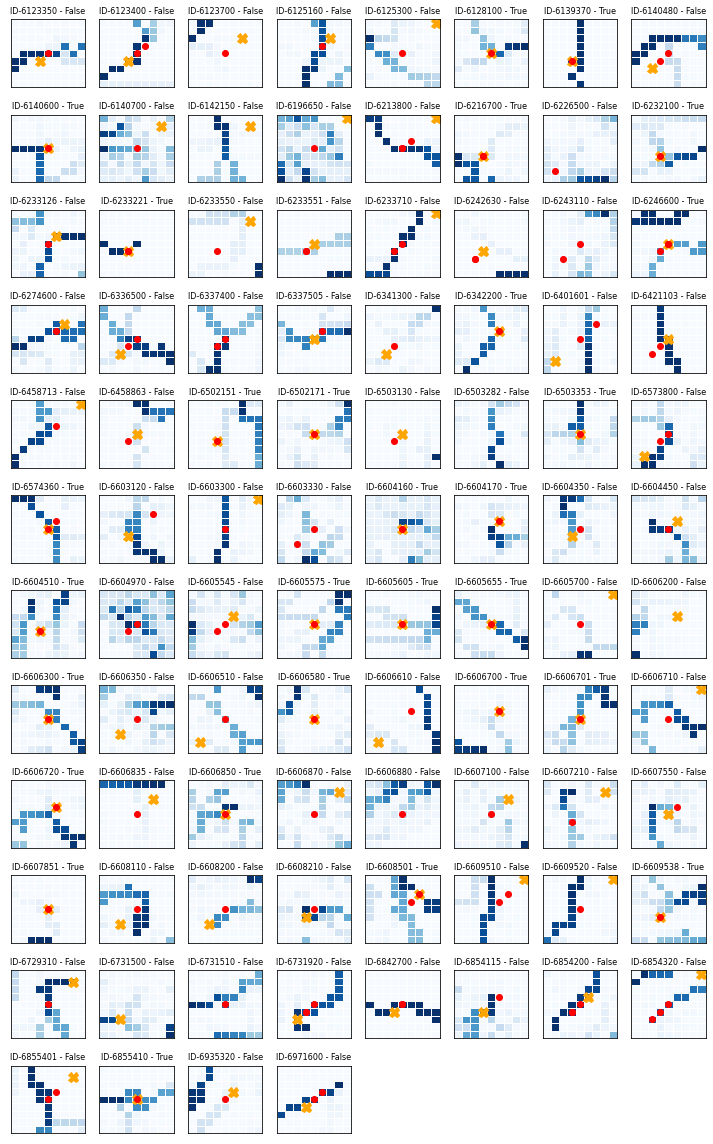

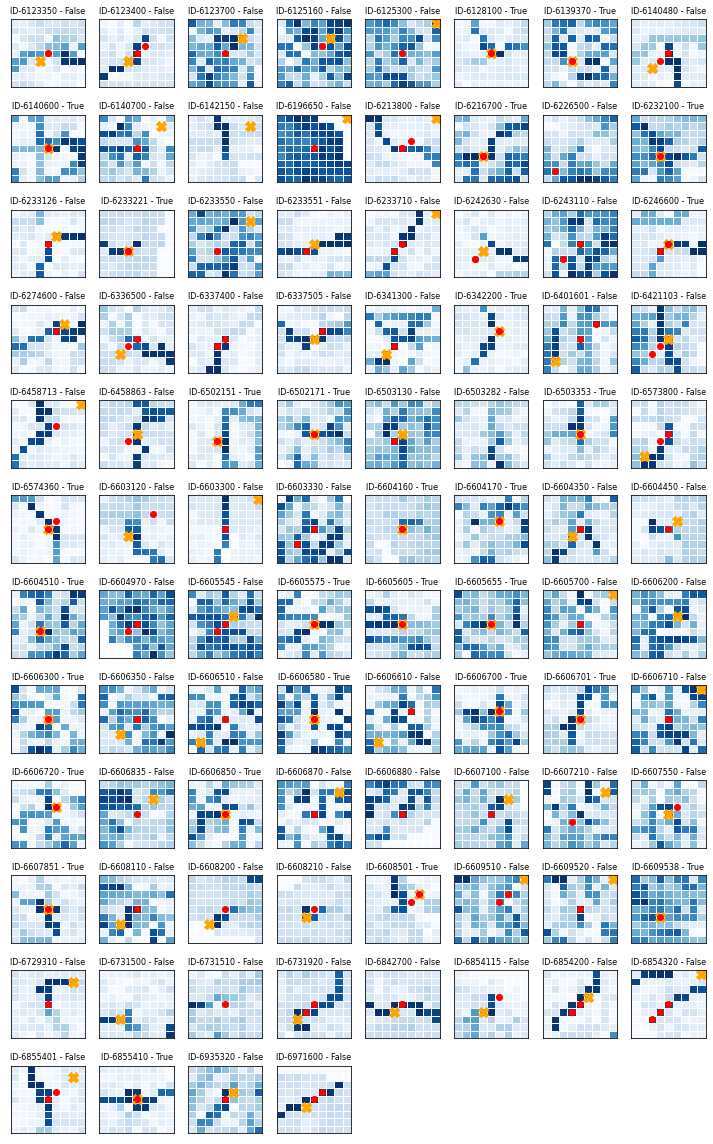

In [41]:
## single classification 
RF_y_hat = class_single_RF['test_RF-single_target']         
RF_y_range = class_single_RF['range_target']                
RF_y_prob = class_single_RF[['test_RF-single_p1', 'tag']]           
id_list = class_single_RF['tag'].unique() 

visualize_classification(RF_y_hat, RF_y_range, df_background, background_var,
                         id_list, buffer_size=set_buffer_size,
                         save_dir = output_dir, fn_stem = f'RF_single_Q_sw_{set_buffer_size}',
                         grid_format=False)

visualize_classification(RF_y_hat, RF_y_range, df_background, background_var,
                         id_list, buffer_size=set_buffer_size,
                         save_dir = output_dir, fn_stem = f'RF_single_prob_sw_{set_buffer_size}',
                         grid_format=False, y_prob = RF_y_prob)

C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_classification_LR_grid_Q_sw_4.png
C:\Users\mvand\Documents\Master EE\Year 4\Thesis\data\test_output\final_analysis\plot_classification_LR_grid_prob_sw_4.png


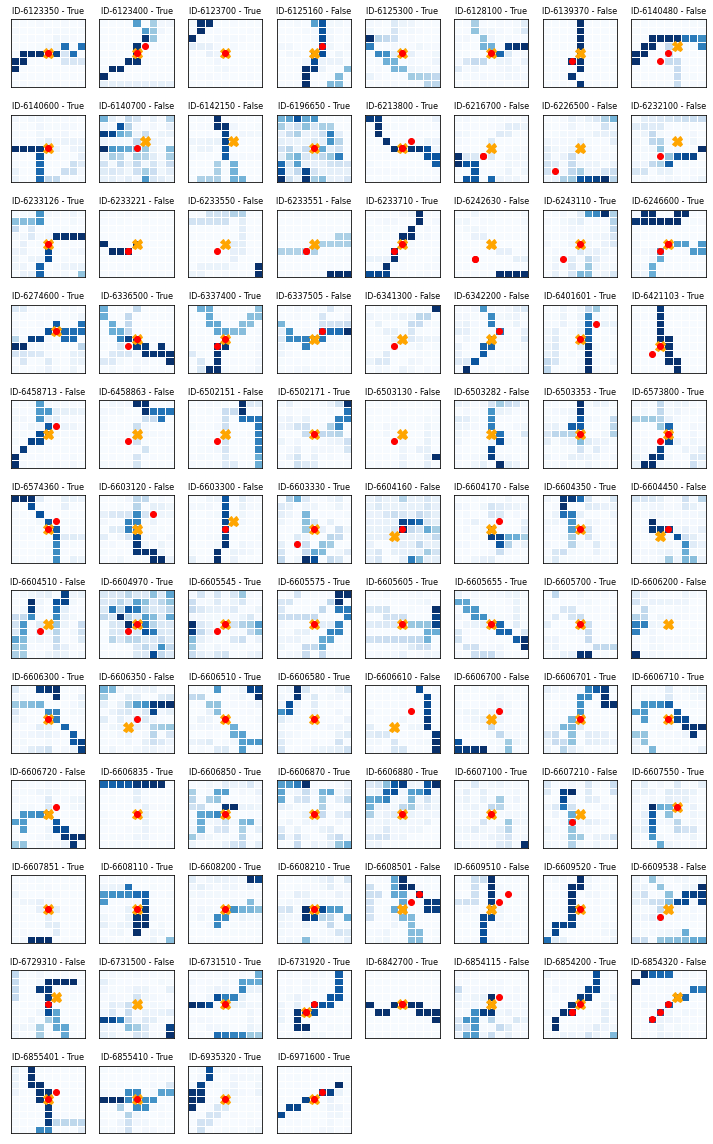

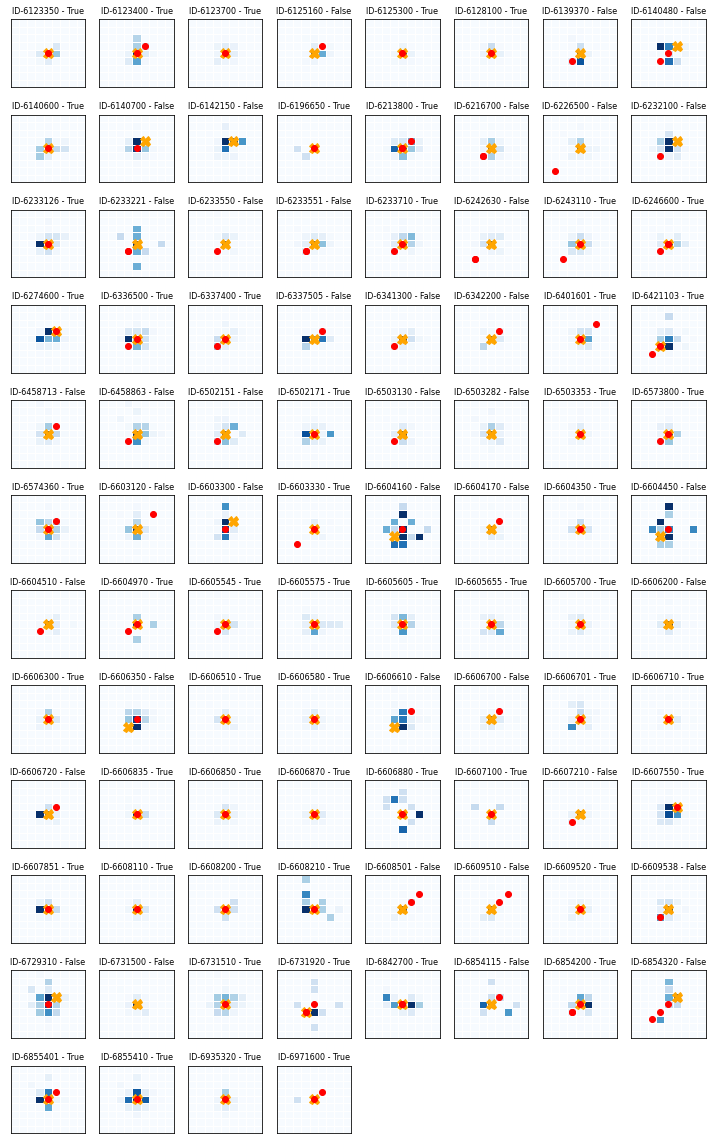

In [42]:
## grid classification 
ds_class_LR = class_grid_LR['LR-grid'][0]

id_list = ds_class_LR.sw_id.values 
LR_y_hat = ds_class_LR['classification']
LR_y_range = ds_class_LR['y_range']
LR_y_prob = ds_class_LR['prob1']

visualize_classification(LR_y_hat, LR_y_range, df_background, background_var,
                         id_list, buffer_size=set_buffer_size,
                         save_dir = output_dir, fn_stem = f'LR_grid_Q_sw_{set_buffer_size}', 
                         grid_format=True)

visualize_classification(LR_y_hat, LR_y_range, df_background, background_var,
                         id_list, buffer_size=set_buffer_size,
                         save_dir = output_dir, fn_stem = f'LR_grid_prob_sw_{set_buffer_size}', 
                         grid_format=True, y_prob = LR_y_prob)